In [58]:
import sys
import os
import platform
import importlib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/data'
    cpuserver_data_FP = '/data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ASCAT_TUW as hASCAT_TUW
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hASCAT_TUW)
importlib.reload(hPlot)
importlib.reload(hData)
importlib.reload(hGrid)

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_data      = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/python_modules/test/subsurface_scattering_ASCAT_ERA5_Land.nc' #cpuserver_data_FP + '/extracted_nc'
output_dir   = '/Users/hyunglokkim/Downloads/'

/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive /Users/hyunglokkim/cpuserver_data


## 0. Basic settings

In [29]:
# get the WARP5 Grid Information (GI) nc file
hData.get_nc_variable_names_units(nc_data);

P_ano_1d = {}
for i in range(1, 13):
    key = str(i)
    var_name = f'P_ano_{i:02}'  # Format the variable name like P_ano_01, P_ano_02, ..., P_ano_12
    data = hData.get_variable_from_nc(nc_data, var_name)
    P_ano_1d[key] = data

P_ano_avg_1d  = hData.get_variable_from_nc(nc_data, 'P_ano') # numeric
S_sub_1d  = hData.get_variable_from_nc(nc_data, 'S_sub') # numeric
P_sub_1d  = hData.get_variable_from_nc(nc_data, 'P_sub') # numeric

cci_lc_1d = hData.get_variable_from_nc(nc_data, 'cci_lc') # numeric
cfvo_1d   = hData.get_variable_from_nc(nc_data, 'cfvo') # numeric
dem_1d    = hData.get_variable_from_nc(nc_data, 'dem') # numeric
lai_1d    = hData.get_variable_from_nc(nc_data, 'lai') # numeric
sand_1d   = hData.get_variable_from_nc(nc_data, 'sand') # numeric

glwd_1d  = hData.get_variable_from_nc(nc_data, 'glwd') #class
isric_1d = hData.get_variable_from_nc(nc_data, 'isric') #class
karst_1d = hData.get_variable_from_nc(nc_data, 'karst') #class
kg_1d    = hData.get_variable_from_nc(nc_data, 'kg') #class

lat = hData.get_variable_from_nc(nc_data, 'lat')
lon = hData.get_variable_from_nc(nc_data, 'lon')

domain_lon, domain_lat = hGrid.generate_lon_lat_e2grid('36km')

+-----------------+------------------------------------------------------------------------------------------+----------------+
| Name            | Long Name                                                                                | Units          |
+=================+==========================================================================================+================+
| gpi             | Grid point index in WARP5 grid                                                           |                |
+-----------------+------------------------------------------------------------------------------------------+----------------+
| lon             | Location longitude                                                                       | degrees_east   |
+-----------------+------------------------------------------------------------------------------------------+----------------+
| lat             | Location latitude                                                                   

In [32]:
# Resampling to the domain_lon/lat
P_ano_3d = np.empty((domain_lon.shape[0], domain_lon.shape[1], 12))
for x in range(12):
    # Format the variable name
    var_name = f'P_ano_{x+1:02}'  # P_ano_01, P_ano_02, ..., P_ano_12

    # Retrieve data from P_ano_1d
    data = P_ano_1d[str(x+1)]  # Use str(x+1) to match the keys in P_ano_1d

    # Resample and assign data to P_ano_3d
    P_ano_3d[:,:,x] = hData.Resampling(
        domain_lon, domain_lat, lon, lat, 
        data, sampling_method='nearest', 
        agg_method='mean', mag_factor=1
    )

# discontinous
P_ano_avg_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, P_ano_avg_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
S_sub_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, S_sub_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
P_sub_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, P_sub_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)

# continuous
cci_lc_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, cci_lc_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
cfvo_2d   = hData.Resampling(domain_lon, domain_lat, lon, lat, cfvo_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
dem_2d    = hData.Resampling(domain_lon, domain_lat, lon, lat, dem_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
lai_2d    = hData.Resampling(domain_lon, domain_lat, lon, lat, lai_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
sand_2d   = hData.Resampling(domain_lon, domain_lat, lon, lat, sand_1d, sampling_method='nearest', agg_method='mean', mag_factor=1)
glwd_2d  = hData.Resampling(domain_lon, domain_lat, lon, lat, glwd_1d, sampling_method='nearest', agg_method='mode', mag_factor=1) #class
isric_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, isric_1d, sampling_method='nearest', agg_method='mode', mag_factor=1) #class
karst_2d = hData.Resampling(domain_lon, domain_lat, lon, lat, karst_1d, sampling_method='nearest', agg_method='mode', mag_factor=1) #class
kg_2d    = hData.Resampling(domain_lon, domain_lat, lon, lat, kg_1d, sampling_method='nearest', agg_method='mode', mag_factor=1) #class

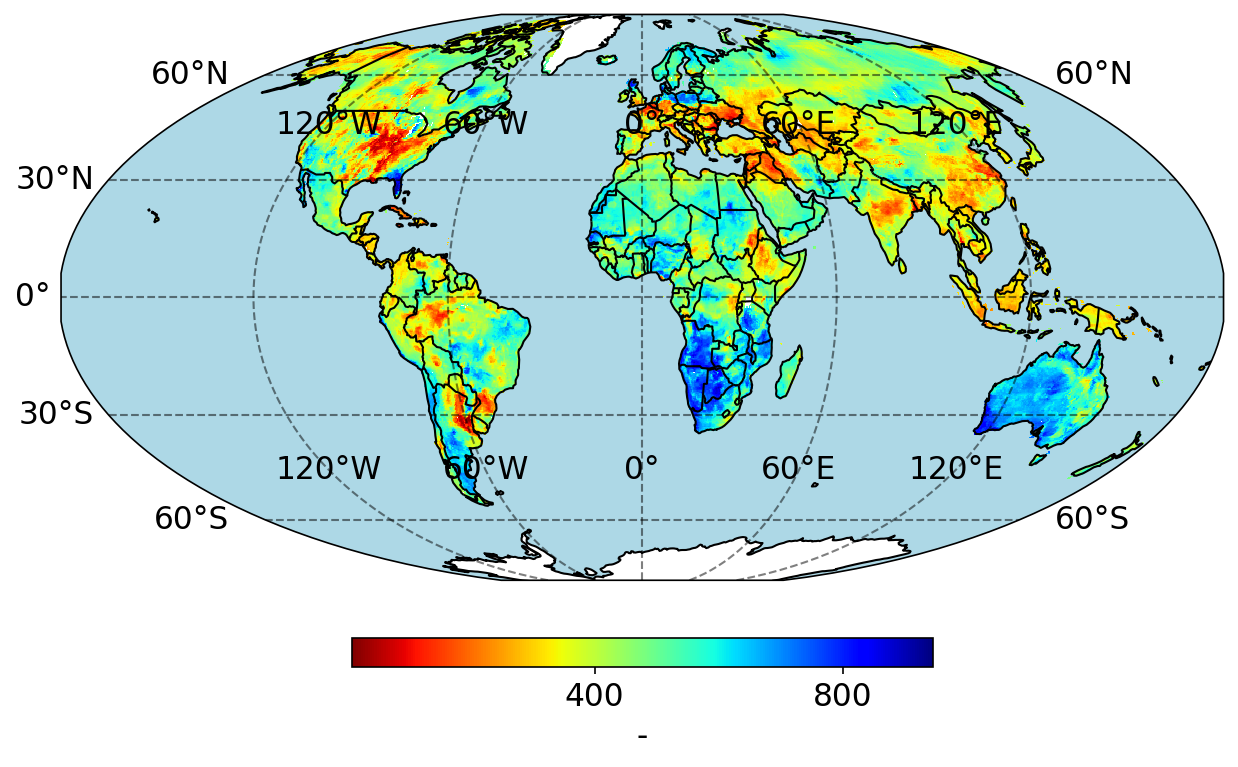

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [47]:
target = sand_2d#P_ano_3d[:,:,6]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='', label_title='-', cmap='jet_r')

In [60]:
# updated create_netcdf_file to accommodate each case by dynamically creating
# the dimensions and ensuring correct shape assignment when writing data into the NetCDF file.
import netCDF4
import numpy as np

def create_netcdf_file(nc_file, longitude, latitude, time_arg='time', **data_vars):
    """
    Creates a NetCDF file from the provided data arrays and latitude/longitude grids.

    Args:
        nc_file (str): Path to the output NetCDF file.
        latitude (np.array): 2D array of latitude values.
        longitude (np.array): 2D array of longitude values.
        data_vars (dict): Dictionary of data arrays to include in the NetCDF file. 
                          Can handle 0D, 1D, 2D, or 3D arrays.
        time_arg (str): Name of the time dimension.

    Returns:
        None
    """
    # Create a new NetCDF file
    nc_data = netCDF4.Dataset(nc_file, 'w')

    # Define the spatial dimensions (latitude and longitude)
    rows, cols = latitude.shape
    nc_data.createDimension('latitude', rows)
    nc_data.createDimension('longitude', cols)

    # Create latitude and longitude variables
    lat_var = nc_data.createVariable('latitude', 'f4', ('latitude', 'longitude'))
    lon_var = nc_data.createVariable('longitude', 'f4', ('latitude', 'longitude'))
    lat_var[:] = latitude
    lon_var[:] = longitude

    # Loop through data variables
    for var_name, var_data in data_vars.items():
        # Handle 0D (scalar), 1D, 2D, and 3D variables separately
        if var_data.ndim == 0:  # 0D scalar
            nc_var = nc_data.createVariable(var_name, 'f4')  # Create scalar variable
            nc_var.assignValue(var_data)
        elif var_data.ndim == 1:  # 1D variable
            time = var_data.shape[0]
            nc_data.createDimension(time_arg, time)
            nc_var = nc_data.createVariable(var_name, 'f4', (time_arg,))
            nc_var[:] = var_data
        elif var_data.ndim == 2:  # 2D variable
            nc_var = nc_data.createVariable(var_name, 'f4', ('latitude', 'longitude'))
            nc_var[:] = var_data
        elif var_data.ndim == 3:  # 3D variable
            time = var_data.shape[2]
            nc_data.createDimension(time_arg, time)  # Time dimension for 3D data
            nc_var = nc_data.createVariable(var_name, 'f4', ('latitude', 'longitude', time_arg))
            nc_var[:, :, :] = var_data
        else:
            raise ValueError(f"Unsupported data dimension: {var_data.ndim}")

    # Close the NetCDF file
    nc_data.close()

    print(f"NetCDF file {nc_file} created successfully.")

In [64]:
t_nc_file_name = os.path.expanduser('~/P_ano_datasets_EASE2_036.nc')

create_netcdf_file(
        nc_file    = t_nc_file_name,
        latitude   = domain_lat,
        longitude  = domain_lon,
        Resampled_P_ano_avg = P_ano_avg_2d,
        Resampled_P_ano_monthly = P_ano_3d,
        Resampled_S_sub = S_sub_2d,
        Resampled_P_sub = P_sub_2d,
        Resampled_cci_lc = cci_lc_2d,
        Resampled_cfvo = cfvo_2d,
        Resampled_dem = dem_2d,
        Resampled_lai = lai_2d,
        Resampled_sand = sand_2d,
        Resampled_glwd = glwd_2d,
        Resampled_isric = isric_2d,
        Resampled_karst = karst_2d,
        Resampled_kg = kg_2d
)

NetCDF file /Users/hyunglokkim/P_ano_datasets_EASE2_036.nc created successfully.
